In [1]:
import numpy as np
import sklearn.utils
import sklearn.preprocessing
import sklearn.metrics
import sklearn.cluster
import sklearn.datasets
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

import autoencoder
import imp # for reloading during dev
Autoencoder = imp.reload(autoencoder).Autoencoder

In [2]:
import pickle, gzip
f = gzip.open('./datasets/mnist.pkl.gz', 'rb')
(train_set,train_set_target), (validation_set,validation_set_target) = [(data, target) for (data,target) in pickle.load(f, encoding='latin1')]
f.close()
# vectorize and normalize
train_set, validation_set = ( np.reshape(data, (data.shape[0],data.shape[1]*data.shape[2])) / 255 for data in (train_set, validation_set))

In [3]:
feature_count, train_set_size, validation_set_size = train_set.shape[1], train_set.shape[0], validation_set.shape[0]
print('Feature Count:', feature_count, 'Training Set Size:', train_set_size, 'Validation Set Size:', validation_set_size)
tolerated_err_per_feature = 0.1
mse_convergence_goal = (tolerated_err_per_feature**2)
mse_upper_bound = (1**2)
ce_convergence_goal = - (0 * np.log(tolerated_err_per_feature) + (1 * np.log(1-tolerated_err_per_feature)))
print('MSE Upper Bound:', mse_upper_bound, ', MSE Convergence Goal:', mse_convergence_goal, 'CE Concergence Goal:', ce_convergence_goal)

Feature Count: 784 Training Set Size: 60000 Validation Set Size: 10000
MSE Upper Bound: 1 , MSE Convergence Goal: 0.010000000000000002 CE Concergence Goal: 0.105360515658


In [4]:
def plot_mnist(data, labels=[]):#, reconstruction=[]):
    if len(labels) is 0:
        labels = np.ones(data.shape[0]) * -1    
    plt.figure(figsize=(20,2))
    for i, (obs,label) in enumerate(zip(data,labels)):#,reconstruction):
        pixels = np.array((obs * 255 - 255) * -1, dtype='uint8')
        pixels = pixels.reshape((28, 28))
        # Plot
        ax = plt.subplot(2, data.shape[0], i + 1)
        if label >= 0:
            plt.title(label)
        plt.grid(False)
        plt.axis('off')
        plt.imshow(pixels, cmap='gray')
    plt.show()

In [11]:
Autoencoder = imp.reload(autoencoder).Autoencoder
ae = Autoencoder([feature_count, (feature_count//3)*2, (feature_count//3) ,32, feature_count//3,(feature_count//3)*2, feature_count], training_set=train_set, validation_set=validation_set, initialize_parameters_method='random_positive')
ae.train(epochs=200, eta=1, mu=0.99, minibatch_size=5000, collect_stats_every_nth_epoch=1, verbose=True)
ae.plot_stats()

Starting training with initial training cost: 816334222806.7224 and validation cost: 825854069323.0219
Epoch 1 Cost: 0.8978916367443768 Cost Validation: 0.8969432852566845
Epoch 2 Cost: 0.8333208872032397 Cost Validation: 0.8324409255303663
Epoch 3 Cost: 0.7423753212803842 Cost Validation: 0.741602915075803
Epoch 4 Cost: 0.641168694970718 Cost Validation: 0.6405345425539752
Epoch 5 Cost: 0.5443651728247418 Cost Validation: 0.5438908626318677
Epoch 6 Cost: 0.46210226122070347 Cost Validation: 0.46179985749128327
Epoch 7 Cost: 0.3986737557057852 Cost Validation: 0.39854608406172143
Epoch 8 Cost: 0.3535138387194564 Cost Validation: 0.3535549443724756
Epoch 9 Cost: 0.32341401513715246 Cost Validation: 0.3236098068539699
Epoch 10 Cost: 0.30448020190364666 Cost Validation: 0.3048098882026052
Epoch 11 Cost: 0.2932192994165743 Cost Validation: 0.2936568130457215
Epoch 12 Cost: 0.28690512982396027 Cost Validation: 0.28742123110120255
Epoch 13 Cost: 0.2835743193007972 Cost Validation: 0.28413800

KeyboardInterrupt: 

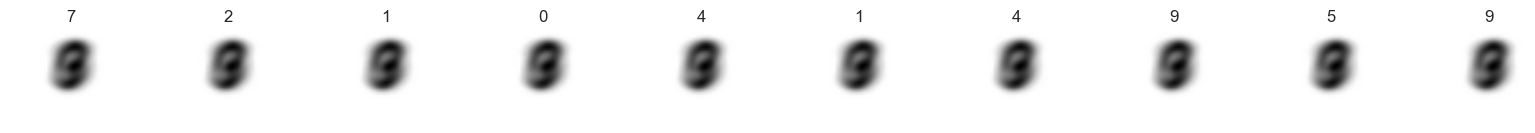

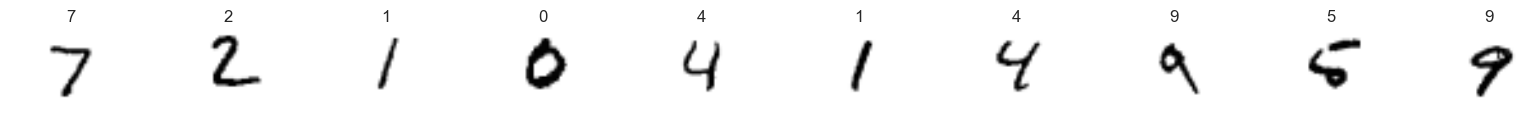

In [12]:
reconstruction = ae.feedforward(validation_set)
plot_mnist(reconstruction[0:10], labels=validation_set_target[0:10])
plot_mnist(validation_set[0:10], labels=validation_set_target[0:10])
encoded = ae.encode(validation_set)

Starting training with initial training cost: 0.2659970993140198 and validation cost: 0.26579966550636086
Epoch 1 Cost: 0.26568978649989494 Cost Validation: 0.26542018254253696


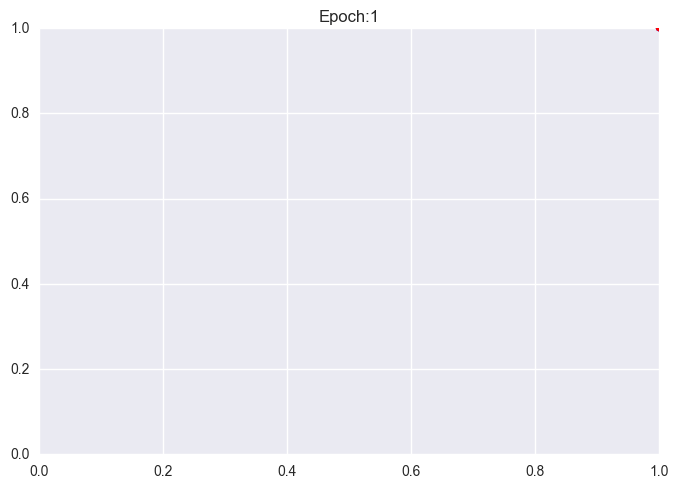

Epoch 2 Cost: 0.2656658269979941 Cost Validation: 0.2654029887991169
Epoch 3 Cost: 0.2659557582436615 Cost Validation: 0.26588968108938615
Training Time: 221.73925399780273 Per Epoch ~ 73.91308466593425


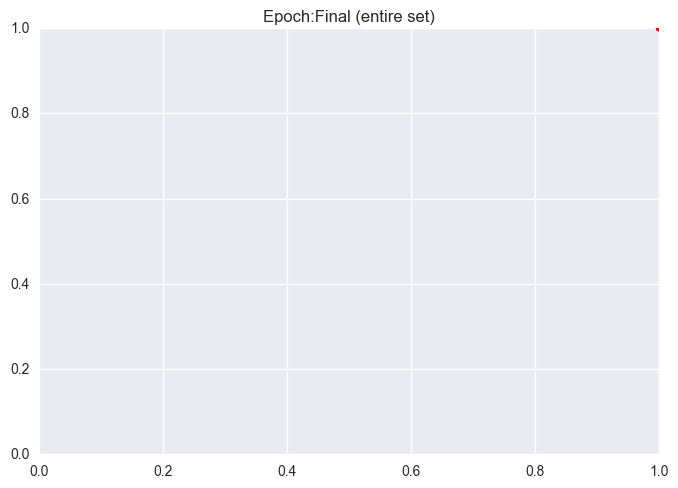

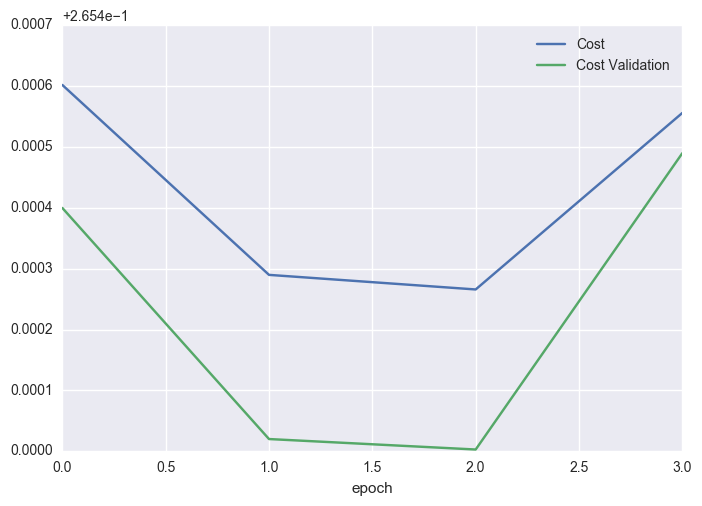

In [24]:
ae.cluster(
    epochs=3, eta=10, mu=0.9, minibatch_size=1001, collect_stats_every_nth_epoch=1, verbose=True,
    k=2, q=0.5, plot_clusters_every_nth_epoch=100
)
ae.plot_stats()


In [ ]:
ae.update_cluster_centroids(data=train_set)

In [ ]:
encoding = ae.encode(validation_set)

In [ ]:
X = np.ones((5,2))
Y = np.random.rand(5,2)
print(Y)
print(X-Y)

In [ ]:
-np.mean(np.sum( (X * np.log(Y)) + (np.ones_like(X) - X) * np.log(np.ones_like(X)-Y),axis=1), axis=0)

In [23]:
methods = [{
    'name': 'K-Means',
    'clustering': sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, n_init=50).fit(validation_set).labels_
},{
    'name': 'Clustering Autoencoder',
    'clustering': clustering_ae.get_cluster_assignment(validation_set)
},{
    'name': 'K-Means on hidden layer of Autoencoder',
    'clustering': sklearn.cluster.KMeans(n_clusters=10, max_iter=1000, n_init=50).fit(encoded).labels_
},{
    'name': 'Spectral Clustering',
    'clustering': sklearn.cluster.SpectralClustering(n_clusters=2, eigen_solver='arpack', affinity="nearest_neighbors").fit(validation_set).labels_
},{
    'name': 'DBScan (k not selectable)',
    'clustering': sklearn.cluster.DBSCAN().fit(validation_set).labels_
}]

results = {}
for m in methods:
    res = results[m['name']] = {}
    res['Adjusted Rand Score'] = sklearn.metrics.adjusted_rand_score(validation_set_target, m['clustering'])
    res['Normalized Mutual Information'] = sklearn.metrics.normalized_mutual_info_score(validation_set_target, m['clustering'])
    res['Adjusted Mutual Information'] = sklearn.metrics.adjusted_mutual_info_score(validation_set_target, m['clustering'])
pd.DataFrame(results)

NameError: name 'name' is not defined